Variables:
<ul>
    <li> Time of the simulation </li>
    <li>Initial state of the system</li>
</ul>

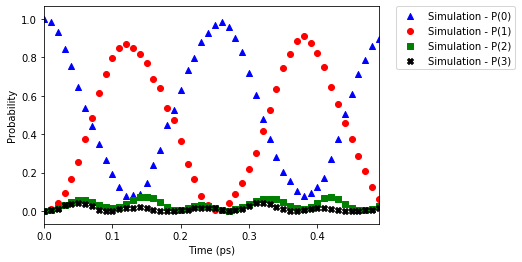

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
import cmath
from math import pi
# Qiskit modules
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, IBMQ
from qiskit import execute
from qiskit import IBMQ
from qiskit import transpile
import qiskit.tools.visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.quantum_info import state_fidelity





# Plot results
def graphic(exc,out,cr,E1,E2,E3,E4,step_size,iterations,init):
    # Required variable declarations
    x=[]
    y1=[]
    y2=[]
    y3=[]
    y4=[]
    p1=0
    p2=0
    p3=0
    p4=0
    for cycles in range(0,iterations):
        qc = QuantumCircuit(exc,anc,out,cr) # each simulation for a time t, needs a new quantum circuit
        two_qubit_fret(qc,exc,anc,out,cr,E1,E2,E3,E4,step_size,cycles,init)
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(qc, backend_sim, shots=5000)
        result_sim = job_sim.result()
        result_counts = result_sim.get_counts(qc)
        
        # Get the population terms
        
        if '00' in result_counts:
            p1+=result_counts['00']/5000
        else:
            p1=0
        if '01' in result_counts:
            p2+=result_counts['01']/5000
        else:
            p2=0
        if '10' in result_counts:
            p3+=result_counts['10']/5000
        else:
            p3=0
        if '11' in result_counts:
            p4+=result_counts['11']/5000
        else:
            p4=0
        x.append(step_size*cycles)
        y1.append(p1)
        y2.append(p2)
        y3.append(p3)
        y4.append(p4)
        p1=0
        p2=0
        p3=0
        p4=0
        
    #Plot the simulation results
    la = plt.scatter(x,y1,c='b',marker="^",label='Simulation - P(0)')
    lb = plt.scatter(x,y2,c='r',label='Simulation - P(1)')
    lc = plt.scatter(x,y3,c='g',marker="s", label='Simulation - P(2)')
    ld = plt.scatter(x,y4,c="black",marker="X",label='Simulation - P(3)')
    ll = plt.legend(loc=7)
    lx = plt.xlabel('Time (ps)')
    ly = plt.ylabel('Probability')
    xx = plt.xlim(0,cycles*step_size)
    ll = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    
    
    
    
    
def ZX(fret,control,target,angle_z,angle_x):        # Implement rotation CU, or 2x2 Rz-x, (as seen in Appendix A).
    fret.cu3(angle_x,-pi/2,pi/2,control,target)
    fret.crz(angle_z,control,target)
    
def ZX_transc(fret,control,target,angle_z,angle_x): # 2X2 Rz-x transconjugate.
    fret.crz(-angle_z,control,target)
    fret.cu3(angle_x,pi/2,-pi/2,control,target) 
    
def phase(fret,controls,anc,target,angle):          # Implement one-level matrix (without the state selection).
    fret.ccx(controls[0],controls[1],anc[0])
    fret.crz(2*angle,anc[0],target)
    fret.ccx(controls[0],controls[1],anc[0])
    
def phase_transc(fret,controls,anc,target,angle):   # one level matrix transconjugate (without the state selection).
    fret.ccx(controls[0],controls[1],anc[0])
    fret.crz(-2*angle,anc[0],target)
    fret.ccx(controls[0],controls[1],anc[0])

    
    
    
    
    
    
# Note: MSB on bottom, LSB on top
# Apply the basis transformation matrix u, "P' " for the one-level matrix, "ZX' " for the two-level matrix

def u(fret,exc,anc):
    fret.barrier()
    #P'10
    fret.x(exc[1])
    fret.x(exc[0])
    phase(fret,exc,anc,out[0],1.767146)
    fret.x(exc[0])
    fret.x(exc[1])
    #P'9
    fret.barrier()
    fret.x(exc[1])
    phase(fret,exc,anc,out[0],2.3561945)
    fret.x(exc[1])
    #P'8
    fret.barrier()
    fret.x(exc[0])
    phase(fret,exc,anc,out[0],-2.8470683)
    fret.x(exc[0])
    #P'7
    fret.barrier()
    phase(fret,exc,anc,out[0],1.8653208)
    #ZX'6
    fret.barrier()
    ZX(fret,exc[1],exc[0],-2.159845,-1.2680365)
    #ZX'5
    fret.barrier()
    ZX(fret,exc[0],exc[1],-1.1780972,-0.103078015)
    #ZX'4
    fret.barrier()
    fret.cx(exc[0],exc[1])
    ZX(fret,exc[1],exc[0],-1.9634955,-0.37569928)
    fret.cx(exc[0],exc[1])
    #ZX'3
    fret.barrier()
    fret.x(exc[1])
    fret.cx(exc[1],exc[0])
    fret.x(exc[1])
    ZX(fret,exc[0],exc[1],-0.392699,-0.06359089)
    fret.x(exc[1])
    fret.cx(exc[1],exc[0])
    fret.x(exc[1])
    #ZX'2
    fret.barrier()
    fret.x(exc[0])
    ZX(fret,exc[0],exc[1],-0.7853982,-0.23925155)
    fret.x(exc[0])
    #ZX'1
    fret.barrier()
    fret.x(exc[1])
    ZX(fret,exc[1],exc[0],-1.5707964,-1.280839)
    fret.x(exc[1])

# Evolution operator of the diagonal Hamiltonian
def hamiltonian_evolution(fret,exc,anc,out,step_size,E1,E2,E3,E4):
    ## state 00
    fret.barrier()
    fret.x(exc[1])
    fret.x(exc[0])
    fret.ccx(exc[1],exc[0],anc[0])
    fret.crz(-E1*step_size,anc[0],out[0])
    fret.ccx(exc[1],exc[0],anc[0])
    fret.x(exc[0])
    fret.x(exc[1])
    ## state 01
    fret.barrier()
    fret.x(exc[1])
    fret.ccx(exc[1],exc[0],anc[0])
    fret.crz(-E2*step_size,anc[0],out[0])
    fret.ccx(exc[1],exc[0],anc[0])
    fret.x(exc[1])
    ## state 10
    fret.barrier()
    fret.x(exc[0])
    fret.ccx(exc[1],exc[0],anc[0])
    fret.crz(-E3*step_size,anc[0],out[0])
    fret.ccx(exc[1],exc[0],anc[0])
    fret.x(exc[0])
    ## state 11
    fret.barrier()
    fret.ccx(exc[1],exc[0],anc[0])
    fret.crz(-E4*step_size,anc[0],out[0])
    fret.ccx(exc[1],exc[0],anc[0])

# Tranconjugate basis transformation matrix

def u_transconj(fret,exc,anc):
    #ZX1
    fret.barrier()
    fret.x(exc[1])
    ZX_transc(fret,exc[1],exc[0],-1.5707964,-1.280839)
    fret.x(exc[1])
    #ZX2
    fret.barrier()
    fret.x(exc[0])
    ZX_transc(fret,exc[0],exc[1],-0.7853982,-0.23925155)
    fret.x(exc[0])
    #ZX3
    fret.barrier()
    fret.x(exc[1])
    fret.cx(exc[1],exc[0])
    fret.x(exc[1])
    ZX_transc(fret,exc[0],exc[1],-0.392699,-0.06359089)
    fret.x(exc[1])
    fret.cx(exc[1],exc[0])
    fret.x(exc[1])
    #ZX4
    fret.barrier()
    fret.cx(exc[0],exc[1])
    ZX_transc(fret,exc[1],exc[0],-1.9634955,-0.37569928)
    fret.cx(exc[0],exc[1])
    #ZX5
    fret.barrier()
    ZX_transc(fret,exc[0],exc[1],-1.1780972,-0.103078015)
    #ZX6
    fret.barrier()
    ZX_transc(fret,exc[1],exc[0],-2.159845,-1.2680365)
    #P7
    fret.barrier()
    phase_transc(fret,exc,anc,out[0],1.8653208)
    #P8
    fret.barrier()
    fret.x(exc[0])
    phase_transc(fret,exc,anc,out[0],-2.8470683)
    fret.x(exc[0])
    #P9
    fret.barrier()
    fret.x(exc[1])
    phase_transc(fret,exc,anc,out[0],2.3561945)
    fret.x(exc[1])
    #P10
    fret.barrier()
    fret.x(exc[1])
    fret.x(exc[0])
    phase_transc(fret,exc,anc,out[0],1.767146)
    fret.x(exc[0])
    fret.x(exc[1])

    
    
    
# Initializes the ancilla at state 1, and initializes the state of the system.
def state_initialization(fret,exc,out,init):
    fret.x(out[0])
    if (init):
        fret.x(exc[1])
        fret.x(exc[0])

        
        
        
# Apply the quantum circuit:
def two_qubit_fret(fret,exc,anc,out,cr,E1,E2,E3,E4,step_size,cycles,init):
    state_initialization(fret,exc,out,init)
    fret.barrier()
    u(fret,exc,anc)
    hamiltonian_evolution(fret,exc,anc,out,cycles*step_size,E1,E2,E3,E4)
    u_transconj(fret,exc,anc)
    fret.barrier()
    fret.measure(exc,cr)

    
    
    
    
exc = QuantumRegister(2) # 4 molecules
anc = QuantumRegister(1) # 1 ancilla initialized at 0
out = QuantumRegister(1) # 1 ancilla initialized at 1
cr = ClassicalRegister(2) # 2 classical bits to measure the system's state
fret = QuantumCircuit(exc,anc,out,cr)

c=0.0299792 #speed of light in cm/ps

# Energy eigenvalues, in rad.THz:
E1=82287.2*c
E2=80637.9*c
E3=77661.3*c
E4=76085.6*c

# time of the simulation: step_size x iterations
step_size=0.01 
iterations=50

init=False # decide if the system starts in the state 00 (False) or 11 (True).

# TOO SEE THE OUTPUT CIRCUIT: (put in comment the call "graphic(....)" and uncomment the following:)
#two_qubit_fret(fret,exc,anc,out,cr,E1,E2,E3,E4,step_size,iterations,init)
#fret.draw(output='mpl')

graphic(exc,out,cr,E1,E2,E3,E4,step_size,iterations,init)